In [1]:
import pandas as pd
import PIL
from PIL import Image
import os
from collections import Counter
import shutil
import cv2
import numpy as np
import pytesseract
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt


## Optical Character recognition

<b>Optical character recognition (OCR) is process of classification of opti-
cal patterns contained in a digital image. The character recognition is achieved
through segmentation, feature extraction and classification.</b>

## Stages of Optical Character Recognition

Stages of the Character Recognition


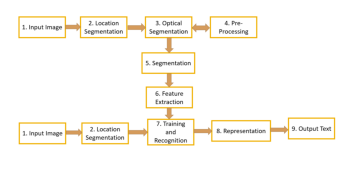

In [2]:
print("Stages of the Character Recognition")
image_path = 'images/steps/image.png' #this image shows the Stages of the process
image_orignal=cv2.imread(image_path) #read the image path
plt.imshow(image_orignal)
plt.axis("off")
plt.show() #display original image that shows the steps
#Image(filename=r'image.png')

## Location Segmentation

The next OCR component is location segmentation. Segmentation determines constituents
of an image. It is necessary to locate regions of document which have
printed data and are distinguished from figures and graphics.

###  Word recogntion through OpenCV

In [3]:
import cv2
import os
import numpy as np
file =  r'sample.jpg'
im1 = cv2.imread(file,0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh1, kernel, iterations = 2)
_,contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    #bound the images
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

cv2.namedWindow('scenery detection', cv2.WINDOW_NORMAL)
cv2.imwrite('BindingBox4.jpg',im)

from IPython.display import Image
Image(filename='sample.jpg')

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def preProcessing():
    print("Importing classes ...")

    for x in range(0, noOfClasses):
        digitList = os.listdir(path + "/" + str(x) )
    
        for y in digitList:
            imagePath = path + "/" + str(x) + "/" +  str(y)
                
            currentImage = cv2.imread(imagePath)    
            currentImage = cv2.cvtColor(currentImage, cv2.COLOR_BGR2GRAY)    
            currentImage=crop_img(currentImage)

            # check the image is empty or not
            if(len(currentImage)==1):
                print("image do not have information: ",imagePath)
            else:
                currentImage = cv2.resize(currentImage, (28,28))  
                currentImage = currentImage/255
                images.append(currentImage)
                classNo.append(x) 
                classNames.append(classes[x])     
        
        
        print(x, end=" ")
preProcessing()

Importing classes ...


NameError: name 'noOfClasses' is not defined

In [ ]:
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from collections import OrderedDict
import importlib
from .utils import CTCLabelConverter
import math

def custom_mean(x):
    return x.prod()**(2.0/np.sqrt(len(x)))

def contrast_grey(img):
    high = np.percentile(img, 90)
    low  = np.percentile(img, 10)
    return (high-low)/np.maximum(10, high+low), high, low

def adjust_contrast_grey(img, target = 0.4):
    contrast, high, low = contrast_grey(img)
    if contrast < target:
        img = img.astype(int)
        ratio = 200./np.maximum(10, high-low)
        img = (img - low + 25)*ratio
        img = np.maximum(np.full(img.shape, 0) ,np.minimum(np.full(img.shape, 255), img)).astype(np.uint8)
    return img

class NormalizePAD(object):

    def __init__(self, max_size, PAD_type='right'):
        self.toTensor = transforms.ToTensor()
        self.max_size = max_size
        self.max_width_half = math.floor(max_size[2] / 2)
        self.PAD_type = PAD_type

    def __call__(self, img):
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        c, h, w = img.size()
        Pad_img = torch.FloatTensor(*self.max_size).fill_(0)
        Pad_img[:, :, :w] = img  # right pad
        if self.max_size[2] != w:  # add border Pad
            Pad_img[:, :, w:] = img[:, :, w - 1].unsqueeze(2).expand(c, h, self.max_size[2] - w)

        return Pad_img

class ListDataset(torch.utils.data.Dataset):

    def __init__(self, image_list):
        self.image_list = image_list
        self.nSamples = len(image_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        img = self.image_list[index]
        return Image.fromarray(img, 'L')

class AlignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio_with_pad=False, adjust_contrast = 0.):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio_with_pad = keep_ratio_with_pad
        self.adjust_contrast = adjust_contrast

    def __call__(self, batch):
        batch = filter(lambda x: x is not None, batch)
        images = batch

        resized_max_w = self.imgW
        input_channel = 1
        transform = NormalizePAD((input_channel, self.imgH, resized_max_w))

        resized_images = []
        for image in images:
            w, h = image.size
            #### augmentation here - change contrast
            if self.adjust_contrast > 0:
                image = np.array(image.convert("L"))
                image = adjust_contrast_grey(image, target = self.adjust_contrast)
                image = Image.fromarray(image, 'L')

            ratio = w / float(h)
            if math.ceil(self.imgH * ratio) > self.imgW:
                resized_w = self.imgW
            else:
                resized_w = math.ceil(self.imgH * ratio)

            resized_image = image.resize((resized_w, self.imgH), Image.BICUBIC)
            resized_images.append(transform(resized_image))

        image_tensors = torch.cat([t.unsqueeze(0) for t in resized_images], 0)
        return image_tensors

def recognizer_predict(model, converter, test_loader, batch_max_length,\
                       ignore_idx, char_group_idx, decoder = 'greedy', beamWidth= 5, device = 'cpu'):
    model.eval()
    result = []
    with torch.no_grad():
        for image_tensors in test_loader:
            batch_size = image_tensors.size(0)
            image = image_tensors.to(device)
            # For max length prediction
            length_for_pred = torch.IntTensor([batch_max_length] * batch_size).to(device)
            text_for_pred = torch.LongTensor(batch_size, batch_max_length + 1).fill_(0).to(device)

            preds = model(image, text_for_pred)

            # Select max probabilty (greedy decoding) then decode index to character
            preds_size = torch.IntTensor([preds.size(1)] * batch_size)

            ######## filter ignore_char, rebalance
            preds_prob = F.softmax(preds, dim=2)
            preds_prob = preds_prob.cpu().detach().numpy()
            preds_prob[:,:,ignore_idx] = 0.
            pred_norm = preds_prob.sum(axis=2)
            preds_prob = preds_prob/np.expand_dims(pred_norm, axis=-1)
            preds_prob = torch.from_numpy(preds_prob).float().to(device)

            if decoder == 'greedy':
                # Select max probabilty (greedy decoding) then decode index to character
                _, preds_index = preds_prob.max(2)
                preds_index = preds_index.view(-1)
                preds_str = converter.decode_greedy(preds_index.data.cpu().detach().numpy(), preds_size.data)
            elif decoder == 'beamsearch':
                k = preds_prob.cpu().detach().numpy()
                preds_str = converter.decode_beamsearch(k, beamWidth=beamWidth)
            elif decoder == 'wordbeamsearch':
                k = preds_prob.cpu().detach().numpy()
                preds_str = converter.decode_wordbeamsearch(k, beamWidth=beamWidth)

            preds_prob = preds_prob.cpu().detach().numpy()
            values = preds_prob.max(axis=2)
            indices = preds_prob.argmax(axis=2)
            preds_max_prob = []
            for v,i in zip(values, indices):
                max_probs = v[i!=0]
                if len(max_probs)>0:
                    preds_max_prob.append(max_probs)
                else:
                    preds_max_prob.append(np.array([0]))

            for pred, pred_max_prob in zip(preds_str, preds_max_prob):
                confidence_score = custom_mean(pred_max_prob)
                result.append([pred, confidence_score])

    return result

def get_recognizer(recog_network, network_params, character,\
                   separator_list, dict_list, model_path,\
                   device = 'cpu', quantize = True):

    converter = CTCLabelConverter(character, separator_list, dict_list)
    num_class = len(converter.character)

    if recog_network == 'generation1':
        model_pkg = importlib.import_module("easyocr.model.model")
    elif recog_network == 'generation2':
        model_pkg = importlib.import_module("easyocr.model.vgg_model")
    else:
        model_pkg = importlib.import_module(recog_network)
    model = model_pkg.Model(num_class=num_class, **network_params)

    if device == 'cpu':
        state_dict = torch.load(model_path, map_location=device)
        new_state_dict = OrderedDict()
        for key, value in state_dict.items():
            new_key = key[7:]
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
        if quantize:
            try:
                torch.quantization.quantize_dynamic(model, dtype=torch.qint8, inplace=True)
            except:
                pass
    else:
        model = torch.nn.DataParallel(model).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))

    return model, converter

def get_text(character, imgH, imgW, recognizer, converter, image_list,\
             ignore_char = '',decoder = 'greedy', beamWidth =5, batch_size=1, contrast_ths=0.1,\
             adjust_contrast=0.5, filter_ths = 0.003, workers = 1, device = 'cpu'):
    batch_max_length = int(imgW/10)

    char_group_idx = {}
    ignore_idx = []
    for char in ignore_char:
        try: ignore_idx.append(character.index(char)+1)
        except: pass

    coord = [item[0] for item in image_list]
    img_list = [item[1] for item in image_list]
    AlignCollate_normal = AlignCollate(imgH=imgH, imgW=imgW, keep_ratio_with_pad=True)
    test_data = ListDataset(img_list)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=False,
        num_workers=int(workers), collate_fn=AlignCollate_normal, pin_memory=True)

    # predict first round
    result1 = recognizer_predict(recognizer, converter, test_loader,batch_max_length,\
                                 ignore_idx, char_group_idx, decoder, beamWidth, device = device)

    # predict second round
    low_confident_idx = [i for i,item in enumerate(result1) if (item[1] < contrast_ths)]
    if len(low_confident_idx) > 0:
        img_list2 = [img_list[i] for i in low_confident_idx]
        AlignCollate_contrast = AlignCollate(imgH=imgH, imgW=imgW, keep_ratio_with_pad=True, adjust_contrast=adjust_contrast)
        test_data = ListDataset(img_list2)
        test_loader = torch.utils.data.DataLoader(
                        test_data, batch_size=batch_size, shuffle=False,
                        num_workers=int(workers), collate_fn=AlignCollate_contrast, pin_memory=True)
        result2 = recognizer_predict(recognizer, converter, test_loader, batch_max_length,\
                                     ignore_idx, char_group_idx, decoder, beamWidth, device = device)

    result = []
    for i, zipped in enumerate(zip(coord, result1)):
        box, pred1 = zipped
        if i in low_confident_idx:
            pred2 = result2[low_confident_idx.index(i)]
            if pred1[1]>pred2[1]:
                result.append( (box, pred1[0], pred1[1]) )
            else:
                result.append( (box, pred2[0], pred2[1]) )
        else:
            result.append( (box, pred1[0], pred1[1]) )

    return result

## Optical Scanning

In OCR optical scanners are used which consist of transport mechanism and sensing device that converts light intensity
into grey levels. Printed documents consist of black print on white background.
When performing OCR multilevel image is converted into bi-level black and white
image. This process known as thresholding is performed on scanner to save memory
space and computational effort. The thresholding process is important as the
results of recognition are totally dependent on quality of bi-level image.

### Character recogntion through OpenCV

In [ ]:
import cv2
import os
import numpy as np
#
file = r'output2/sample.jpg'
#file = r'/home/naga/Documents/Naga/Machine Learning/Data_extract/data/1 (3).jpg'
im1 = cv2.imread(file,0)
im = cv2.imread(file)
ret,thresh1 = cv2.threshold(im1,180,278,cv2.THRESH_BINARY)
_,contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
	x,y,w,h = cv2.boundingRect(cnt)
	#bound the images
	cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
i=0
for cnt in contours:
	x,y,w,h = cv2.boundingRect(cnt)
	#following if statement is to ignore the noises and save the images which are of normal size(character)
	#In order to write more general code, than specifying the dimensions as 100,
	# number of characters should be divided by word dimension
	if w>100 and h>100:
		#save individual images
		cv2.imwrite(str(i)+".jpg",thresh1[y:y+h,x:x+w])
		i=i+1
cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('output2/BindingBox3.jpg',im)
from IPython.display import Image
Image(filename='output2/BindingBox3.jpg')

## Characters recognised through pytesseract (creating boundaries)

In [ ]:
# read the image and get the dimensions
img = cv2.imread(file)
h, w, _ = img.shape # assumes color image

# run tesseract, returning the bounding boxes
boxes = pytesseract.image_to_boxes(img).split('\n') # 
# Box = list(map(lambda box:(box[:1],list(map(int,box[2:][:-2].split(' ')))),boxes))

# draw the bounding boxes on the image
for b in boxes:
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
# show annotated image and wait for keypress
# cv2.imshow(files[0], img)

cv2.imwrite('exboxe.jpg',img)

from IPython.display import Image
Image(filename='exboxe.jpg')

IndexError: list index out of range

In [ ]:
contours[0].shape

(8, 1, 2)

In [ ]:
# For each contour, find the bounding rectangle and draw it
count = 0
for component in zip(contours, hierarchy[0]):
    currentContour = component[0]
    currentHierarchy = component[1]
    x,y,w,h = cv2.boundingRect(currentContour)
    if currentHierarchy[3] <= 0:
        # these are the outermost parent components
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,128),1)
        count = count + 1
        letter = im[y:y+h,x:x+w]
        cv2.imwrite('output2/words/l-{}.jpg'.format(count),letter)
#     elif currentHierarchy[2] < 0:
#         # these are the innermost child components
#         cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)

# Finally show the image
cv2.imwrite('img.jpg',im)
print(count)

102


## Pre-processing

1) The raw data depending on the data
acquisition type is subjected to a number of preliminary processing steps to make it
usable in the descriptive stages of character analysis. The image resulting from scanning
process may contain certain amount of noise

2) Smoothing implies both filling
and thinning. Filling eliminates small breaks, gaps and holes in digitized characters
while thinning reduces width of line.

    (a) noise reduction

    (b) normalization of the data and

    (c) compression in the amount of information to be retained.

### a.  Noise Reduction
Noise reduction: The noise introduced by the optical scanning device or the
writing instrument causes disconnected line segments, bumps and gaps in
lines, filled loops, etc. The distortion including local variations, rounding of
corners, dilation and erosion is a potential problem.
    
    (i) filtering
    (ii) morphological operations and 
    (iii) noise modeling.

### b. Normalization: 
The normalization methods aim to remove the variations of the
writing and obtain standardized data. Some of the commonly used methods
for normalization are 
    
    (i) skew normalization and baseline extraction
    (ii) slant normalization 
    (iii) size normalization and 
    (iv) contour smoothing

In [ ]:
# reading label for all image data
letters = [j[:-4][-1] for j in os.listdir(r'data\words')]
letter_dict = dict([(k,[j for j in os.listdir(r'data\words') if j[:-4][-1] ==k])  for k in Counter(letters).keys()])

In [ ]:
encod_y = dict(zip(np.unique(letters),np.arange(len(np.unique(letters)))))

In [ ]:
for i in letter_dict['.']:
    shutil.copyfile(r'data\words\\'+i,r'data\letters\check\\'+i)

In [ ]:
# # Copying each label data in specific folder name by creating
# import shutil
# for i in letter_dict.keys():
#     if not os.path.exists(r'data\letters\\'+i):
#         os.mkdir(r'data\letters\\'+i)
#     for j in letter_dict[i]:
#         shutil.copyfile(r'data\words\\'+j,r'data\letters\\'+i+'\\'+j)
        

In [ ]:
# # Duplicating the files with different names for each less than 10 number
# to_copy = [(i,j) for i,j in Counter(letters).items() if j < 50]
# for key in to_copy:
#     for let in letter_dict[key[0]]:
#         [shutil.copyfile(r'data\words\\'+let,r'data\words\\l-'+str(co)+'-l'+key[0]+'.jpg') for co in np.arange(4010,4060)]

In [ ]:
data = []
data_y = []
for key in letter_dict.keys():
    for let in letter_dict[key]:
        im = PIL.Image.open(os.path.join(r'data\words',let))
        data.append(np.array(im.resize([32,32],PIL.Image.ANTIALIAS)))
        data_y.append(encod_y[key])
        
#Image.fromarray(da1[345])
data = np.array(data).reshape((len(data),32,32,3))
data_y = np.array(data_y).reshape(len(data_y),1)

In [ ]:
shfl = np.arange(len(data))
np.random.shuffle(shfl)

In [ ]:
X_train,y_train = data[shfl[:int(len(data)*0.8)]],data_y[shfl[:int(len(data)*0.8)]]
X_test,y_test = data[shfl[int(len(data)*0.8):]],data_y[shfl[int(len(data)*0.8):]]

In [ ]:
n = 376
for i in encod_y.keys():
    if encod_y[i]==data_y[n][0]:
        print(i)
PIL.Image.fromarray(data[n])

In [ ]:
for i in encod_y.keys():
    if encod_y[i]==y_train[n][0]:
        print(i)
PIL.Image.fromarray(X_train[n])

In [ ]:
def format_text(details):
    """
    This function take one argument as
    input.This function will arrange
    resulted text into proper format.
    :param details: dictionary
    :return: list
    """
    parse_text = []
    word_list = []
    last_word = ''
    for word in details['text']:
        if word != '':
            word_list.append(word)
            last_word = word
        if (last_word != '' and word == '') or (word == details['text'][-1]):
            parse_text.append(word_list)
            word_list = []

    return parse_text


def write_text(formatted_text):
    """
    This function take one argument.
    it will write arranged text into
    a file.
    :param formatted_text: list
    :return: None
    """
    with open('resulted_text.txt', 'w', newline="") as file:
        csv.writer(file, delimiter=" ").writerows(formatted_text)


Preprocess or reduce the dimenstions using PCA
Steps involved in the PCA

Here is the short summary of the required steps:

    Standardize the dataset — our dataset has 784 features and a total of 4833
    Calculate the covariance matrix for the features in the dataset
    Calculate the eigenvalues and eigenvectors for the covariance matrix
    Pick K eigenvalues and form eigenvectors
    Transform the original matrix
    Reconstruction from Principal Component
    Visualize the data

Standardize the dataset:

Standardize features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:
𝑧=(𝑥−𝑢)𝑠
where 𝑢 is the mean of the training samples or zero if with_mean=False, and 𝑠 is the standard deviation of the training samples or one if with_std=False.

In [ ]:
mean_ = X.mean(axis=0)

# print("mean",mean_)
std_ = X.std(axis=0)
# print("std",std_)

X_scaled = (X-mean_)/std_

Calculate Covariance Matrix:

Variance reports variation of a single random variable, and covariance reports how much two random variables vary. On the diagonal of the covariance matrix we have variances, and other elements are the covariances. Covariance matrix has larger diagonal values(variance) and non diagonal values (covariance) are very small.

The formula to calculate the covariance matrix:
𝐶𝑜𝑣(𝑥,𝑦)=∑𝑛𝑖=1(𝑥𝑖−𝑥⎯⎯⎯)(𝑦𝑖−𝑦⎯⎯⎯)𝑛−1

In [ ]:
print(f'Shape of X_scaled: {X_scaled.shape}')
features = X_scaled.T
print(f'Shape of features: {features.shape}')
cov_matrix = np.cov(features)
print(f'Shape of cov_matrix: {cov_matrix.shape}')
print('\nSneak Peak of the covariance matrix:\n')
cov_matrix[0:4, 0:4]

Calculate the eigenvalues and eigenvectors

Eigendecomposition is a process that decomposes a square matrix into eigenvectors and eigenvalues. Eigenvectors are simple unit vectors, and eigenvalues are coefficients which give the magnitude to the eigenvectors.

It turns out, eigenvectors of symmetric matrices are orthogonal. For PCA this means that we have the first principal component which explains most of the variance. Orthogonal to that is the second principal component, which explains most of the remaining variance. This is repeated for N number of principal components, where N equals to number of original features.

And this turns out to be neat for us — principal components are sorted by percentage of variance explained, as we can decide how many should we keep. For example, if we have 100 features originally, but the first 3 principal components explain 95% of the variance, then it makes sense to keep only these 3 for visualizations and model training.


In [ ]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)



print(f'First 10 eigenvalues: {eig_values[:10]}')
print(f'\n\nLast 10 eigenvalues: {eig_values[-10:]}')


In [ ]:
plt.figure(figsize=(10,7))
plt.stem(eig_values[:200], use_line_collection = True)
plt.xlabel('Eigen value index')
plt.ylabel('Eigen value')
plt.show()

In [ ]:
for i in range(200):
    exp_var = np.sum(eig_values[:i+1])*100 / np.sum(eig_values)
    print(f'Eigenvectors upto {i+1} expresses {exp_var} % variance')

Visualizations
Eigenvector Visualization¶


In [ ]:
# Covariance Matrix
X_scaled[0].reshape((-1, 784)).shape

In [ ]:
# eigen vectors
eig_vectors[:, 0].reshape((784, -1)).shape

Pick K eigenvalues and form eigenvectors

In [ ]:
K= [2,3,5,10,20,50,100,200,300,500,700,780]

In [ ]:
result_pca = []
for k in K:
    result = np.dot(X_scaled.reshape((-1, 784)), eig_vectors[:,:k].reshape((784, -1)))
    result_pca.append(result)
   

In [ ]:
projected_1 = X_scaled.dot(eig_vectors.T[0])
projected_2 = X_scaled.dot(eig_vectors.T[1])
res2d = pd.DataFrame(projected_1, columns=['PC1'])
res2d['PC2'] = projected_2
res2d['Y'] = classNames
res2d.head()

In [ ]:
#CNN model 
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import keras
import keras_metrics
K.set_image_dim_ordering('th')
import tensorflow as tf
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage


def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

# load data
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
y_train_unq, y_train_ids = np.unique(y_train, return_inverse=True)
y_test_unq,y_test_ids  = np.unique(y_test, return_inverse=True)

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train_ids,len(y_train_unq))
y_test = keras.utils.np_utils.to_categorical(y_test_ids,len(y_test_unq))

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)



In [ ]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1213: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (2218, 32, 32, 3) (32 channels).
  ' channels).')


In [ ]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32,3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

# model.compile(loss='categorical_crossentropy', optimizer=sgd, 
#               metrics=['categorical_accuracy',keras_metrics.precision(), keras_metrics.recall()])
class_value = 1
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = [auc_pr]) 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
__________

In [ ]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),validation_data=(X_test,y_test),
                    steps_per_epoch=len(X_train) / 32, epochs=50)

# # here's a more "manual" example
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(x_train) / 32:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

In [ ]:
model.predict(X_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_.argmax(1)

NameError: name 'y_code' is not defined

In [ ]:
model.predict(X_test).argmax(1)

array([26, 29, 26, 29, 33, 29, 29, 26, 26, 26, 26, 26, 26, 39, 26, 29, 26,
       26, 26, 26, 26, 29, 33, 29, 26, 26, 29, 29, 26, 26, 26, 29, 26, 29,
       39, 26, 29, 26, 26, 29, 26, 26,  1, 26, 26, 26, 26, 29, 26, 29, 29,
       26, 26, 29, 26, 29, 26, 26, 33, 26, 26, 29, 26, 26, 29, 26, 33, 26,
       26, 26, 26, 26, 39, 26, 26, 26, 29, 26, 29, 26, 29, 29, 26, 29, 26,
       26, 26, 26, 26, 26, 29, 26,  1, 26, 26, 29, 26, 29, 26, 26, 26, 29,
       26, 26, 26, 29, 26, 29, 26, 26, 29, 26, 29, 26, 26, 29, 26, 26, 26,
       26, 29, 26, 26, 29, 26, 26, 26, 26, 26, 29, 26, 26, 26, 26, 29, 29,
       26, 29, 26, 26, 26, 26, 26, 29, 29, 26, 29, 26, 26, 29, 26, 26, 26,
       26,  1, 26, 29, 26, 26, 26, 29, 26, 26, 26, 26, 26, 29, 29, 29, 29,
       29, 26, 26, 29, 26, 26, 29, 29, 26, 26, 29, 29, 26, 26, 29, 26, 26,
       29, 33,  1, 29, 33, 29, 26, 26, 33, 26, 29, 26, 39, 26, 26, 26, 26,
       29, 33, 26, 26, 26,  1, 39, 26,  1, 29, 33, 26, 26, 26, 26, 26, 33,
       26, 26, 29, 26, 29

In [ ]:
uniques, ids = np.unique(y_train, return_inverse=True)

array([19, 20,  4, ..., 32, 34, 10], dtype=int64)

In [ ]:
keras.utils.np_utils.normalize(model.predict(X_test))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
df = pd.DataFrame()
df['Rand'] = np.random.uniform(0,1,10)

Classification using KNN

Used k-nearest neighbor (KNN) to locate the nearby projections made by the training images, to do this

    Step 1: Calculate Euclidean Distance-We can calculate the straight line distance between two vectors using the Euclidean distance measure. It is calculated as the square root of the sum of the squared differences between the two vectors.
    𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒=∑𝑖=1𝑛(𝑝1𝑖−𝑝2𝑖)2⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

Step 2: Get Nearest Neighbors - Neighbors for a new piece of data in the dataset are the k closest instances(for our case k=5), as defined by our distance measure. To locate the neighbors for a new piece of data within a dataset we must first calculate the distance between each record in the dataset to the new piece of data. We can do this using our distance function prepared above. Once distances are calculated, we must sort all of the records in the training dataset by their distance to the new data. We can then select the top k to return as the most similar neighbors. We can do this by keeping track of the distance for each record in the dataset as a tuple, sort the list of tuples by the distance (in descending order) and then retrieve the neighbors.

Step 3: Make Predictions, - The most similar neighbors collected from the training dataset can be used to make predictions.In the case of classification, we can return the most represented class among the neighbors. We can achieve this by performing the argmax() function on the list of output values from the neighbors. Given a list of class values observed in the neighbors, the argmax() function takes a set of unique class values and calls the count on the list of class values for each class value in the set.

Step 4: Measure Accuracy- we are tried to show accuracy levels with different numbers of eigenvectors for pca and lda


In [ ]:
# Calculate the Euclidean distance between two vectors
def euclidean(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))

In [ ]:
def knn(X_train, y_train, test_point, k=5):
    
    distances = [] # Contains list of tuples (distance, label
    
    for data_point, label in zip(X_train, y_train):
        distances.append((euclidean(test_point, data_point), label))
 
    
    sorted_distances = sorted(distances, key=lambda x: x[0])
    k_nearest_neighbors = np.array(sorted_distances[:k])
    freq = np.unique(k_nearest_neighbors[:,1], return_counts=True)
    labels, counts = freq
    majority_vote = labels[counts.argmax()]
    return majority_vote

In [ ]:
def calculate_accuracy(X_test, y_test, X_train, y_train, k=5):
    
    predictions = []
    
    for test_point in X_test:
        
        pred_label = knn(X_train, y_train, test_point, k)
        predictions.append(pred_label)
    
    predictions = np.array(predictions)

    
    
  
    accuracy = (predictions == y_test).sum() / y_test.shape[0]
    return accuracy

In [ ]:
accuracy_list_pca= []

for pca in result_pca:
    X_test, y_test, X_train, y_train=prepareDataForTrainingTesting(pca)
    accuracy=calculate_accuracy(X_test, y_test, X_train, y_train, k=5)
    accuracy_list_pca.append(accuracy)

In [ ]:
accuracy_list_lda = []
for lda in result_lda:
    X_test, y_test, X_train, y_train=prepareDataForTrainingTesting(lda)
    accuracy=calculate_accuracy(X_test, y_test, X_train, y_train, k=5)
    accuracy_list_lda.append(accuracy)

In [ ]:
i =0
for accyracy in accuracy_list_pca:
    print("When the eigenvector value {} the accuracy result {}%".format(K[i],accyracy*100))
    i=i+1

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(K, accuracy_list_pca)
plt.title('Accuracy vs Eigenvector on PCA')
plt.xlabel('Number of Eigenvector used')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
i =0
for accyracy in accuracy_list_lda:
    print("When the eigenvector value {} the accuracy result {}%".format(K[i],accyracy*100))
    i=i+1

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(K, accuracy_list_lda)
plt.title('Accuracy vs Eigenvector on LDA')
plt.xlabel('Number of Eigenvector used')
plt.ylabel('Accuracy')
plt.show()